In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Bonds') + ['AGG', 'BND', 'BNDX', 'BIV', 'SCHZ'], 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-18 to 2019-07-19 - 77


In [3]:
stats = quote.statistics()
stats = stats[(stats['shrp'] > 0) & (stats['std'] > 0.01)]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

65


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
TLT,60,0.123419,0.236848,0.487578,7.808488,3.084717
SPTL,60,0.122648,0.228036,0.503042,7.738045,2.930501
BLV,60,0.115121,0.190649,0.562208,7.452854,2.488783
VCLT,60,0.111082,0.195654,0.527183,7.228176,2.439522
EMLC,60,0.088268,0.211323,0.380136,5.254631,3.406279
LQD,60,0.080389,0.133505,0.542695,5.308884,1.584890
EMB,60,0.076831,0.147096,0.468368,4.763286,1.290153
VWOB,60,0.075716,0.116474,0.581930,4.805314,0.872579
IEF,60,0.072587,0.111971,0.577384,4.678627,1.233113


evicted BSCK 0.747 -0.242
evicted LMBS 0.739 -0.277
evicted IBDL 0.773 -0.358
evicted FLRN 0.399 -0.214
evicted VTIP 0.788 -0.336
evicted SUB 0.500 -0.406
evicted IGIB 0.773 -0.257
evicted BWX 0.611 -0.301
evicted CWB 0.785 -0.486
evicted EMB 0.782 -0.353
evicted NUV 0.312 -0.185
evicted EMLC 0.369 -0.454
evicted HYD 0.688 -0.311
evicted SRLN -0.168 -0.490
evicted BNDX 0.060 -0.066
retry backlogs ['SHY', 'BSV', 'STIP', 'GOVT', 'AGG', 'SJNK', 'BIV', 'MUB', 'SPTL', 'IEI', 'TIP', 'SCHP', 'VGSH', 'VCSH', 'TDTT', 'SPSB', 'MBB', 'VMBS', 'BND', 'SCHO', 'BSJK', 'IGSB', 'BLV', 'TLT', 'USIG', 'IPE', 'ISTB', 'SPTS', 'SCHR', 'VTEB', 'SCHZ', 'VCIT', 'HYG', 'VGIT', 'IEF', 'LQD', 'SLQD', 'SPIB', 'JNK', 'VCLT', 'HYLS', 'PZA', 'HYS', 'SHYG', 'VWOB', 'TFI', 'HYLB', 'ITM'] at 0.805/-0.51 - 1.335
evicted SPTL 0.653 0.193
evicted VCLT 0.753 -0.011
evicted VWOB -0.097 -0.328
retry backlogs ['VCSH', 'SCHP', 'STIP', 'SHY', 'VGSH', 'BSV', 'VTEB', 'TIP', 'BSJK', 'MBB', 'SHYG', 'SCHO', 'SPTS', 'TLT', 'GOVT', 'TD

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.040036,0.024061,-0.006180,0.022040,0.038030,0.056246,0.096031,1.334082,2.581564,0.165714
CMF,60.0,0.049136,0.035085,-0.016544,0.025569,0.046728,0.067291,0.147935,1.174283,3.194290,0.181783
SHM,60.0,0.027481,0.018724,-0.013229,0.015954,0.025711,0.039451,0.071845,1.043843,1.742333,0.143406


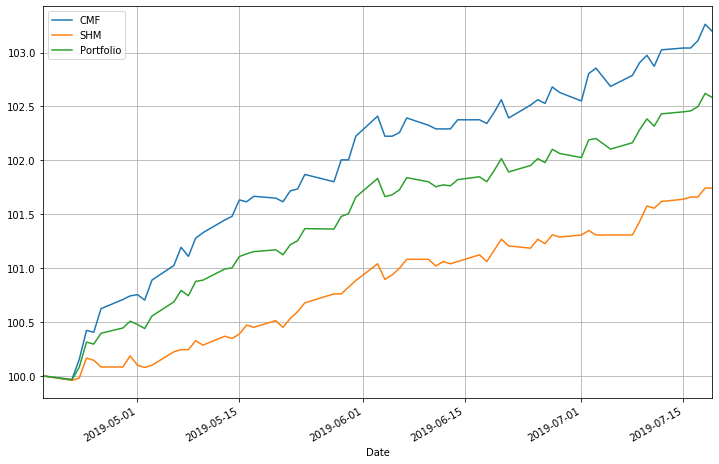

In [4]:
bounds = .04, .08
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(max_count=2, backlogs_pos_threshold=.8, _lambda=2, bounds=bounds)
quote.setup_mask(['CMF', 'SHM'])
sd.update(quote.optimize_portfolio(max_count=2, _lambda=2, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(max_count=2, _lambda=2, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)